# **Setup**

In [ ]:
!git clone https://github.com/niyaryca/Idiomacity-Detection.git

fatal: destination path 'Idiomacity-Detection' already exists and is not an empty directory.


In [ ]:
!pip install transformers
%cd /content/ 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import site
site.main()

In [ ]:
import os
import csv

from pathlib import Path

# **Pre-process Data**

In [ ]:
def load_csv( path, delimiter=',' ) : 
  header = None
  data   = list()
  with open( path, encoding='utf-8') as csvfile:
    reader = csv.reader( csvfile, delimiter=delimiter ) 
    for row in reader : 
      if header is None : 
        header = row
        continue
      data.append( row ) 
  return header, data

In [ ]:
def write_csv( data, location ) : 
  with open( location, 'w', encoding='utf-8') as csvfile:
    writer = csv.writer( csvfile ) 
    writer.writerows( data ) 
  print( "Wrote {}".format( location ) ) 
  return

In [ ]:
class Node():
  def __init__(self, sentence, label):
    self.sentence = sentence
    self.label = label

def create_idiom_dict_train(data_location, file_name) :
    idiom_dict = {}
    file_name = os.path.join( data_location, file_name ) 
    header, data = load_csv( file_name )
    for elem in data:
        label     = elem[ header.index( 'Label'  ) ]
        sentence = elem[ header.index( 'Target' ) ]
        idiom = elem[ header.index( 'MWE' ) ]
        if idiom in idiom_dict:
          idiom_dict[idiom].append(Node(sentence, label))
        else:
          idiom_dict[idiom] = [Node(sentence, label)]
    return idiom_dict

In [ ]:
d1 = create_idiom_dict_train('/content/Idiomacity-Detection/Rawdata', 'train_zero_shot.csv')
d2 = create_idiom_dict_train('/content/Idiomacity-Detection/Rawdata', 'train_one_shot.csv')
for key, value in d2.items():
  if key in d1:
    d1[key].append(value)
  else:
    d1[key] = value

In [ ]:
def _get_train_data( data_location, file_name ) :
    
    file_name = os.path.join( data_location, file_name ) 

    header, data = load_csv( file_name )

    out_header = [ 'label1', 'label2', 
                  'sentence1', 'sentence2', 
                  'sentence3', 'sentence4' ]
        
    out_data = list()
    for elem1 in data :
        label     = elem1[ header.index('Label' ) ]
        sentence1 = elem1[ header.index('Target') ]
        for elem2 in d1[elem1[ header.index('MWE')]]:
          if elem2.sentence != sentence1:
              label2     = elem2.label
              sentence2 = elem2.sentence
              sentence3 = elem1[ header.index( 'MWE' ) ]
              sentence4 = sentence3
              this_row = [ label, label2, sentence1, sentence3, sentence2, sentence4]
              out_data.append( this_row )
              assert len( out_header ) == len( this_row )
    return [ out_header ] + out_data

In [ ]:
def _get_dev_eval_data( data_location, input_file_name, gold_file_name) :

    input_headers, input_data = load_csv( os.path.join( data_location, input_file_name ) )
    gold_header  = gold_data = None
    if not gold_file_name is None : 
        gold_header, gold_data  = load_csv( os.path.join( data_location, gold_file_name  ) )
        assert len( input_data ) == len( gold_data )

    out_header = [ 'label1', 'label2', 'label3', 'sentence1', 'sentence2', 'sentence3', 'sentence4', 'sentence5', 'sentence6', 'language' ]

    out_data = list()
    for index in range( len( input_data ) ) :
        label = 1
        if not gold_file_name is None : 
            this_input_id = input_data[ index ][ input_headers.index( 'ID' ) ]
            this_gold_id  = gold_data [ index ][ gold_header  .index( 'ID' ) ]
            assert this_input_id == this_gold_id
            
            label     = gold_data[ index ][ gold_header.index( 'Label'  ) ]
            language = gold_data[index][gold_header.index('Language')]
        elem = input_data[ index ]
        sentence1 = elem[ input_headers.index( 'Target' ) ]
        sentence2 = elem[ input_headers.index( 'MWE' ) ]
        this_row = [ label, sentence1, sentence2 ]
        idiom = elem[ input_headers.index( 'MWE' ) ]
        other_nodes = d1[idiom]
        if(len(other_nodes)==1):
            sentence2 = elem[ input_headers.index( 'MWE' ) ]
            this_row = [ label, other_nodes[0].label, other_nodes[0].label, sentence1, sentence2, other_nodes[0].sentence, sentence2, other_nodes[0].sentence, sentence2, language ]
        else:
            sentence2 = elem[ input_headers.index( 'MWE' ) ]
            this_row = [ label, other_nodes[0].label, other_nodes[1].label, sentence1, sentence2, other_nodes[0].sentence, sentence2, other_nodes[1].sentence, sentence2, language ]
           
        assert len( out_header ) == len( this_row ) 
        out_data.append( this_row )
        

    return [ out_header ] + out_data

In [ ]:
def create_data( input_location, output_location ) :

    train_zero_data = _get_train_data(
        data_location   = input_location,
        file_name       = 'train_zero_shot.csv'
    )
    train_one_data = _get_train_data(
        data_location   = input_location,
        file_name       = 'train_one_shot.csv'
    )

    assert train_zero_data[0] == train_one_data[0] ## Headers
    train_data = train_one_data + train_zero_data[1:]
    write_csv( train_data, os.path.join( output_location, 'OneShot', 'train.csv' ) )
    
    dev_data = _get_dev_eval_data(
        data_location    = input_location,
        input_file_name  = 'dev.csv',
        gold_file_name   = 'dev_gold.csv'
        
    )        
    write_csv( dev_data, os.path.join( output_location, 'OneShot', 'dev.csv' ) )
    

    return

In [ ]:
train_zero_data = _get_train_data(
        data_location   = '/content/Idiomacity-Detection/Rawdata',
        file_name       = 'train_zero_shot.csv'
    )
train_one_data = _get_train_data(
        data_location   = '/content/Idiomacity-Detection/Rawdata',
        file_name       = 'train_one_shot.csv'
    )

assert train_zero_data[0] == train_one_data[0] ## Headers
train_data = train_one_data + train_zero_data[1:]

dev_data = _get_dev_eval_data(
        data_location    = '/content/Idiomacity-Detection/Rawdata',
        input_file_name  = 'dev.csv',
        gold_file_name   = 'dev_gold.csv'
    )

In [ ]:
outpath = 'Data'

Path( os.path.join( outpath, 'ZeroShot' ) ).mkdir(parents=True, exist_ok=True)
Path( os.path.join( outpath, 'OneShot' ) ).mkdir(parents=True, exist_ok=True)


# **Implementation of Siamese Network**

In [ ]:
import os
import sys
import numpy as np
import random
import pickle
import logging

from typing          import Optional
from dataclasses     import dataclass, field
from sklearn.metrics import *

from datasets        import load_dataset, load_metric

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from keras_preprocessing.sequence import pad_sequences
import torch


import transformers
from transformers import (
    AutoConfig,
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    PretrainedConfig,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
)
from transformers.utils         import check_min_version
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers.trainer_utils import get_last_checkpoint, is_main_process

In [ ]:
# Will error if the minimal version of Transformers is not installed. Remove at your own risks.
check_min_version("4.6.0.dev0")

task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

logger = logging.getLogger(__name__)

In [ ]:
train_data

[['label1', 'label2', 'sentence1', 'sentence2', 'sentence3', 'sentence4'],
 ['0',
  '1',
  'Program leaders said the scholarship defines public service broadly and imagines a variety of pathways toward civic engagement.',
  'public service',
  'In the ensuing years, Wennberg might not have managed to knock down the parking deck, but his administration helped keep Central Vermont Public Service from moving its corporate headquarters out of the city, and after successfully fighting a number of shopping centers city officials worried would pose a threat to downtown, he negotiated a deal that kept Diamond Run Mall from hosting a movie theater or supermarket and got the city a couple million dollars in payments that funded a variety of projects through the years.',
  'public service'],
 ['1',
  '0',
  'In the ensuing years, Wennberg might not have managed to knock down the parking deck, but his administration helped keep Central Vermont Public Service from moving its corporate headquarters 

In [ ]:
dev_data

[['label1',
  'label2',
  'label3',
  'sentence1',
  'sentence2',
  'sentence3',
  'sentence4',
  'sentence5',
  'sentence6',
  'language'],
 ['1',
  '1',
  '1',
  'Are these interruptions of the good life a necessary condition of the high life?',
  'high life',
  'Despite having the riches to afford the high life, PSG captain Marquinhos is still in touch with his past life before becoming a multi-millionaire footballer.',
  'high life',
  'Despite having the riches to afford the high life, PSG captain Marquinhos is still in touch with his past life before becoming a multi-millionaire footballer.',
  'high life',
  'EN'],
 ['1',
  '1',
  '1',
  "But for Australian fashion designer Abby Kheir, there's no reason not to treat her employees to a taste of the high life all-year round.",
  'high life',
  'Despite having the riches to afford the high life, PSG captain Marquinhos is still in touch with his past life before becoming a multi-millionaire footballer.',
  'high life',
  'Despite ha

# **Tokenizing**

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base',
                                          cache_dir=None,
                                          use_fast=True,
                                          revision="main",
                                          use_auth_token=None,)

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:

def Preprocess_Data(input, tokenizer, max_len, batch_size):
    
    sentence_mwe1, sentence_mwe2, first_label, second_label = ([] for i in range(4))

    for i in input:
      first_label.append(int(i[0]))
      second_label.append(int(i[1]))
      sentence_mwe1.append((i[2], i[3]))
      sentence_mwe2.append((i[4], i[5]))

    #tokenizing first sentence
    sentence1_encoded = tokenizer(sentence_mwe1, padding='max_length', max_length = max_len, truncation=True, return_tensors="pt")
    #tokenizing second sentence
    sentence2_encoded = tokenizer(sentence_mwe2, padding='max_length', max_length = max_len, truncation=True, return_tensors="pt")
    
    dataset_tensor = TensorDataset(sentence1_encoded['input_ids'], sentence1_encoded['attention_mask'], torch.tensor(first_label), 
                                   sentence2_encoded['input_ids'], sentence2_encoded['attention_mask'], torch.tensor(second_label))

    dataloader = DataLoader(dataset_tensor, sampler=RandomSampler(dataset_tensor), batch_size=batch_size)

    return dataloader

In [ ]:
max_len = 512
batch_size = 32
def PreProcess_Dev(input, tokenizer, max_len, batch_size):
    
    sentence_mwe1, sentence_mwe2, sentence_mwe3, first_label, second_label, third_label, LN = ([] for i in range(7))
    for i in input:
      
      first_label.append(int(i[0]))
      second_label.append(int(i[1]))
      third_label.append(int(i[2]))
      sentence_mwe1.append((i[3], i[4]))
      sentence_mwe2.append((i[5], i[6]))
      sentence_mwe3.append((i[7], i[8]))
      LN.append(0) if i[9] =='EN' else LN.append(1)
     
    sentence1_encoded = tokenizer(sentence_mwe1, padding='max_length', max_length = max_len, truncation=True, return_tensors="pt")
    sentence2_encoded = tokenizer(sentence_mwe2, padding='max_length', max_length = max_len, truncation=True, return_tensors="pt")
    sentence3_encoded = tokenizer(sentence_mwe3, padding='max_length', max_length = max_len, truncation=True, return_tensors="pt")

    dataset_tensor = TensorDataset(sentence1_encoded['input_ids'], sentence1_encoded['attention_mask'], torch.tensor(first_label), 
                                   sentence2_encoded['input_ids'], sentence2_encoded['attention_mask'], torch.tensor(second_label), 
                                   sentence3_encoded['input_ids'], sentence3_encoded['attention_mask'], torch.tensor(third_label), 
                                   torch.tensor(LN))

    sampler = SequentialSampler(dataset_tensor)
    dataloader = DataLoader(dataset_tensor, sampler=sampler, batch_size=batch_size)

    return dataloader

# **Siamese Model**

In [ ]:
import torch.nn as nn
class SiameseModel(nn.Module):
    def __init__(self):
        super(SiameseModel, self).__init__()
        
        self.base_model = AutoModel.from_pretrained(
            'xlm-roberta-base',
            from_tf=bool(".ckpt" in 'xlm-roberta-base'),
            config=config,
            cache_dir=None,
            revision="main",
            use_auth_token=None,
        ).cuda()
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(768, 2).cuda() 
        
    def forward(self, input_1_id, attention_1_mask, input_2_id, attention_2_mask):
        
        first_output = self.base_model(input_1_id, attention_mask=attention_1_mask).last_hidden_state[:, 0]
        second_output = self.base_model(input_2_id,attention_mask=attention_2_mask).last_hidden_state[:, 0]
        
        outputs = self.dropout(first_output*second_output) #similarity score (dot product)
        outputs = self.linear(outputs)
        
        return outputs

In [ ]:
from tqdm import tqdm

def Train_Eval(model, train_data, learning_rate, number_of_epochs, tokenizer, batch_size, maximum_length):

    optimizer = AdamW(model.parameters(), 
                      lr=learning_rate,
                      no_deprecation_warning=True)
    model.train()

    #tokenizing training data
    train_dataloader = Preprocess_Data(train_data, tokenizer, maximum_length, batch_size)
       
    # TRAIN loop
    for epoch in range(number_of_epochs):
        print(f"\nEpoch {epoch}")
        torch.cuda.empty_cache()
        trainloss = 0
        training_samples, training_steps = 0, 0
        for step, batch in enumerate(tqdm(train_dataloader)):
            batch = tuple(t.to(device) for t in batch)
            model.zero_grad()
            # forward pass
            logits = model.forward(batch[0], batch[1], batch[3], batch[4])
            loss = 0
            # if any of the sentence is idiomatic, the the combined target would be idiomatic
            target = torch.where(batch[2]==batch[5], 1, 0)
            
            #computes the cross entropy loss between input logits and target.
            loss = nn.functional.cross_entropy(logits, target)
            
            #Computes the gradient of current tensor
            loss.backward()
            # For tracking the loss for each batch
            trainloss += loss.item() # item() returns the value of this tensor as int number
            training_steps += 1

            # updates parameters
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            #does a single optimization step
            optimizer.step()

        # print train loss per epoch
        print("Train loss on epoch {}: {}\n".format(epoch, trainloss / training_steps))

# **Training the Model**

In [ ]:
config = AutoConfig.from_pretrained(
        'xlm-roberta-base',
        num_labels=2,
        finetuning_task=None,
        cache_dir=None,
        revision="main",
        use_auth_token=None,
    )

model = SiameseModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
                         
torch.cuda.empty_cache()

if n_gpu > 1:
    model.to(device)
    model = torch.nn.DataParallel(model)
else:
    model.cuda()

Train_Eval(model, train_data[1:], learning_rate = 2e-5, number_of_epochs = 2,tokenizer = tokenizer, batch_size=16, maximum_length=128)


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Epoch 0


100%|██████████| 5387/5387 [1:07:42<00:00,  1.33it/s]


Train loss on epoch 0: 0.15164876402553246


Epoch 1


100%|██████████| 5387/5387 [1:07:43<00:00,  1.33it/s]

Train loss on epoch 1: 0.017131457494615088



# Testing the Model

In [ ]:
def metrics(true_labels, predictions):
    p_labels,t_label = ([] for i in range(2))
    num_correct = 0
    for pred, true_label in zip(predictions, true_labels):
        p_labels.append(int(pred.item()))
        t_label.append(int(true_label.item()))
        if pred == true_label:
            num_correct += 1
    accuracy = float(num_correct) / float(len(true_labels))
    f1 = f1_score(t_label, p_labels, average='macro')
    return accuracy,f1,t_label,p_labels

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
def Eval(transformer_model, dataloader):

    transformer_model.eval()
    predictions, true_labels,predictions_en, true_labels_en,predictions_pt, true_labels_pt = ([] for i in range(6))
    
    for step, batch in enumerate(tqdm(dataloader)):
        batch = tuple(t.to(device) for t in batch)
        
        #batch[0] = sentence1, batch[1] = attention1, batch[2] =labels1
        #batch[3]= sentence2, batch[4] = attention2, batch[5] =labels2
        #batch[6]= sentence2, batch[7] = attention3, batch[8] =labels3
        #batch[9] = language
        with torch.no_grad():
            #applies softmax function between anchor sentence & positive sentence & returns a tensor
            first_tensor = nn.functional.softmax(transformer_model.forward(batch[0], batch[1], batch[3], batch[4]), -1)
            #applies softmax function between anchor sentence & negative sentence & returns a tensor
            second_tensor = nn.functional.softmax(transformer_model.forward(batch[0], batch[1], batch[6], batch[7]), -1)

        #concatenates two tensors to desired dimension
        logits = torch.cat((first_tensor, second_tensor), dim=1)

        #returns the index where maximum value exists
        max_args = torch.argmax(logits, dim=1)

        batch_both_real_label,first_sentence_labels,second_sentence_labels,LN = batch[2], batch[5], batch[8],batch[9]
        batch_both_predicted_label, batch_en_predicted_label,batch_pt_predicted_label, batch_en_real_label, batch_pt_real_label,sentence_individual = ([] for i in range(6))

        for idx, instance in enumerate(max_args):
          instance_individual = instance.item()
          mapping = {0: lambda x: (x - 1) * -1, 1: lambda x: x, 2: lambda x: (x - 1) * -1, 3: lambda x: x}
            
          batch_both_predicted_label.append(mapping[instance_individual](first_sentence_labels[idx] if instance_individual < 2 else second_sentence_labels[idx]))
          if LN[idx].item() == 0:
            batch_en_predicted_label.append(mapping[instance_individual](first_sentence_labels[idx] if instance_individual < 2 else second_sentence_labels[idx]))
            batch_en_real_label.append(batch_both_real_label[idx])
          else:
            batch_pt_predicted_label.append(mapping[instance_individual](first_sentence_labels[idx] if instance_individual < 2 else second_sentence_labels[idx]))
            batch_pt_real_label.append(batch_both_real_label[idx])

        predictions += batch_both_predicted_label
        true_labels += batch_both_real_label
        predictions_en += batch_en_predicted_label
        predictions_pt += batch_pt_predicted_label
        true_labels_en += batch_en_real_label
        true_labels_pt += batch_pt_real_label
    return true_labels, predictions, true_labels_en, predictions_en, true_labels_pt, predictions_pt

In [ ]:
#tokenizing testing data
dev_dataloader = PreProcess_Dev(dev_data[1:], tokenizer, 128, 32)
true_labels, predictions, true_labels_en, predictions_en, true_labels_pt, predictions_pt  = Eval(model, dev_dataloader)

import pandas as pd

d = {
     'Language': ['EN-PT','EN', 'PT'],
     'Accuracy': [metrics(true_labels,predictions)[0],metrics(true_labels_en,predictions_en)[0],metrics(true_labels_pt,predictions_pt)[0]],
     'F1_Score(Macro)':[metrics(true_labels,predictions)[1],metrics(true_labels_en,predictions_en)[1],metrics(true_labels_pt,predictions_pt)[1]]}
results_ensemble = pd.DataFrame(data=d)
results_ensemble.head(3)

100%|██████████| 24/24 [00:19<00:00,  1.24it/s]


,Language,Accuracy,F1_Score(Macro)
0,EN-PT,0.853857,0.853360
1,EN,0.862661,0.860021
2,PT,0.838828,0.837868


### **Confusion Matrix(EN-PT)**

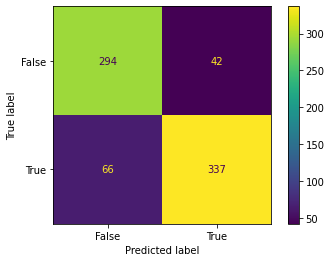

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(metrics(true_labels,predictions)[2],metrics(true_labels,predictions)[3]), display_labels = [False, True]).plot()

### **Confusion Matrix(English)**

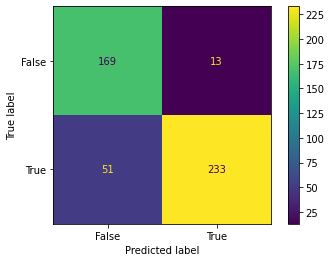

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(metrics(true_labels_en,predictions_en)[2],metrics(true_labels_en,predictions_en)[3]), display_labels = [False, True]).plot()

### **Confusion Matrix(Portuguese)**

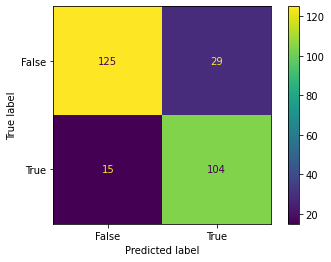

In [ ]:
metrics(true_labels_pt,predictions_pt)[1]
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(metrics(true_labels_pt,predictions_pt)[2],metrics(true_labels_pt,predictions_pt)[3]), display_labels = [False, True]).plot()

In [2]:
%%shell
jupyter nbconvert --to html 2_XLM_Roberta_Siamese.ipynb

[NbConvertApp] Converting notebook 2_XLM_Roberta_Siamese.ipynb to html
[NbConvertApp] Writing 1318947 bytes to 2_XLM_Roberta_Siamese.html
